In [ ]:
from typing import Annotated, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from pydantic.networks import AnyUrl
from langchain_core.messages import HumanMessage
from src.utils.scrapper import ZonaPropScrapper
import json

In [ ]:
load_dotenv()

llm = init_chat_model("ollama:gemma3:12b")

class MessageURL(BaseModel):
    url: AnyUrl = Field(description="A functional ZonaProp URL based on the user's real estate query")

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    query: Annotated[list, add_messages]
    url: AnyUrl | None
    properties: Optional[list] = None
    analysis: str | None


graph_builder = StateGraph(State)


def url_agent(state: State):
    last_message = state["query"][-1]
    url_llm = llm.with_structured_output(MessageURL)

    result = url_llm.invoke([
        {
            "role": "system",
            "content": f"""
                You are an assistant that generates ZonaProp property listing URLs based on the user's message.

                ## ZonaProp URL Format
                Base structure:
                https://www.zonaprop.com.ar/[property-type]-[operation]-[location]-[additional-filters].html

                ### Required Components (must always be included):
                1. **Property Type**
                - departamentos (apartments)
                - casas (houses)
                - ph (Horizontal Property)
                - cocheras (parking)
                - terrenos (land)
                - oficinas (offices)
                - locales (commercial)
                - Combined types: e.g., casas-departamentos-ph

                2. **Operation**
                - venta (sale)
                - alquiler (rent)
                - alquiler-temporal (temporary rental)

                3. **Location**
                - Examples: capital-federal, palermo, la-plata, rosario
                - Can include neighborhoods, cities, or provinces

                ---

                ### Optional Filters (include only if user provides relevant info):
                4. **Rooms (ambientes)**
                - e.g., 1-ambiente, 2-ambientes, mas-de-3-ambientes, desde-2-hasta-3-ambientes

                5. **Bedrooms (habitaciones)**
                - e.g., 1-habitacion, hasta-3-habitaciones, desde-2-hasta-3-habitaciones

                6. **Bathrooms (baños)**
                - e.g., 2-banos, mas-de-1-bano, desde-1-hasta-2-banos

                7. **Garages**
                - e.g., 1-garage, sin-garages, mas-de-1-garage, desde-1-hasta-2-garages

                8. **Price**
                - e.g., menos-200000-dolares, mas-de-100000-pesos, desde-100000-hasta-300000-dolares

                9. **Age**
                - e.g., a-estrenar, hasta-10-anos, mas-de-20-anos

                10. **Sorting**
                - orden-precio-ascendente
                - orden-publicacion-descendente

                11. **Publication Date**
                - publicado-hoy
                - publicado-hace-menos-de-1-semana
                - publicado-hace-menos-de-1-mes

                ---

                ### Rules & Behavior
                - All terms in the URL must be lowercase and hyphen-separated.
                - If key info is missing, **infer as a real estate agent would** or omit the filter.
                - **Always include** property type, operation, and location.
                - **Only output the URL.**
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ])
    return {"url": result.url}

def scrape_node(state: State):
    sc = ZonaPropScrapper()
    url = str(state["url"])
    urls = sc.generate_pagination_urls(url, 1)
    htmls = sc.selenium_scrape(urls)
    properties = sc.parse_property_listings(htmls)
    return {"properties": properties}

def analize_agent(state: State):
    last_message = state["query"][-1]

    result = llm.invoke([
        {
            "role": "system",
            "content": f"""
                You are a real estate analysis assistant specializing in properties located in La Plata, Argentina.

                PROPERTY LISTINGS:
                {json.dumps(state["properties"], indent=2, ensure_ascii=False)}

                Please analyze these properties based on the user's query. Focus on the following points:

                - Which properties best match the user's criteria
                - Price comparison and value assessment
                - Pros and cons of the locations
                - Notable features or amenities
                - Any other relevant observations

                Present your analysis in a clear, structured, and easy-to-understand format.
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ])

    return {"analysis": [result]}

def recomend_agent(state: State):
    last_message = state["query"][-1]

    result = llm.invoke([
        {
            "role": "system",
            "content": f"""
                Based on the following analysis of real estate listings in La Plata and the user query:
                
                {state["analysis"][0].content}

                Generate between 3 and 5 specific recommendations for the user. For each recommendation, provide:

                -The URL of the property.

                -A brief justification (1–2 sentences).

                -Key advantages of this property.

                -Key disadvantages of this property.
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ])
    
    return {"query": [result]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("url_agent", url_agent)
graph_builder.add_node("scrape_node", scrape_node)
graph_builder.add_node("analize_agent", analize_agent)
graph_builder.add_node("recomend_agent", recomend_agent)

graph_builder.add_edge(START, "url_agent")
graph_builder.add_edge("url_agent", "scrape_node")
graph_builder.add_edge("scrape_node", "analize_agent")
graph_builder.add_edge("analize_agent", "recomend_agent")
graph_builder.add_edge("recomend_agent", END)


graph = graph_builder.compile()

user_input = input("Enter a message: ")
state = graph.invoke({"query": [HumanMessage(content=user_input)]})

print(state["query"][-1].content)

Accessing webpage: https://www.zonaprop.com.ar/departamentos-alquiler-la-plata-desde-2-ambientes.html


KeyError: 'messages'

In [12]:
state["analysis"][0].content

'¡Claro! Buscar un departamento en La Plata para una persona con 2 o más ambientes en una buena zona del casco urbano es una excelente idea. Aquí te doy algunas sugerencias y zonas a considerar, junto con cómo buscar propiedades:\n\n**Zonas Recomendadas en el Casco Urbano de La Plata:**\n\n*   **Centro:** Es el corazón de la ciudad, con fácil acceso a todo (transporte, comercios, universidades, parques). Ideal si buscas vida urbana y cercanía a servicios. Los precios suelen ser más altos.\n*   **Núñez:** Una zona residencial tranquila y elegante, con calles arboladas, casas antiguas y buena calidad de vida. A pocos minutos del centro.\n*   **Ingeniero Budini:** Similar a Núñez, con ambiente tranquilo y familiar. Bien conectado con el centro y otros puntos de la ciudad.\n*   **Vista Moderna:** Una zona más moderna, con edificios nuevos y amenidades. Un poco más alejada del centro, pero bien comunicada.\n*   **Arroyo Seco:** Una zona con encanto, con casas antiguas y un ambiente tranquil

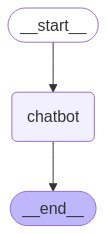

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass